In [1]:
import os
import time
import glob
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
from torchvision import transforms

from torchvision.models import resnet18

device = "cuda" if torch.cuda.is_available() else "cpu"

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2)
torch.cuda.empty_cache()

## Улучшение качества обучения нейросетей

### Загрузка данных

In [2]:
data_dir = "data/simpsons_dataset"
data_image_paths = glob.glob(f"{data_dir}/*/*.jpg")
data_image_labels = [path.split('/')[-2] for path in data_image_paths]
train_files_path, val_files_path = train_test_split(
    data_image_paths, 
    test_size=0.3,
    stratify=data_image_labels
)

print(f"Изображений в train: {len(train_files_path)}\nИзображений в val: {len(val_files_path)}")

Изображений в train: 14653
Изображений в val: 6280


In [3]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ColorJitter(0.9, 0.9, 0.9),
    transforms.RandomAffine(5),
    transforms.ToTensor(),
])


val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [4]:
print("Количество классов в train: ", len(train_dataset.classes))
print("Количество классов в val: ", len(val_dataset.classes))
print("Количество классов одинаково: ", len(train_dataset.classes) == len(val_dataset.classes))

Количество классов в train:  42
Количество классов в val:  42
Количество классов одинаково:  True


In [5]:
sns.set_style(style='white')

def show_images(dataset):
    fig, ax = plt.subplots(
        nrows=2, ncols=3, figsize=(8, 6),
        sharey=True, sharex=True
    )

    for fig_x in ax.flatten():
        idx = np.random.randint(low=0, high=6000)
        img, label = dataset[idx]
        fig_x.set_title(dataset.classes[label])
        fig_x.imshow(img.numpy().transpose((1, 2, 0)))

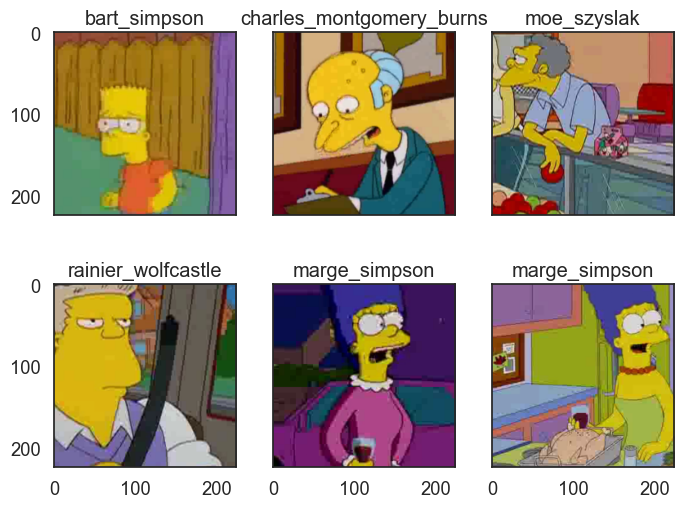

In [6]:
show_images(val_dataset)

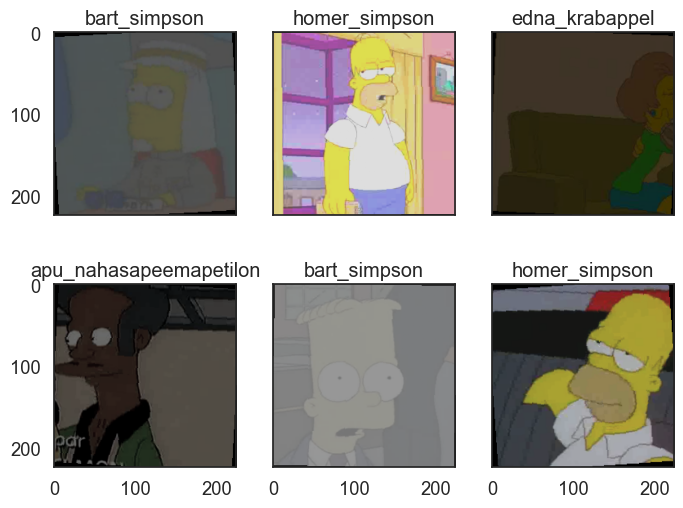

In [7]:
show_images(train_dataset)

### Создание DataLoader

In [8]:
def plot_learning_curves(history):
    '''
    Функция для вывода графиков лосса и метрики во время обучения.
    '''
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Точность', fontsize=15)
    plt.plot(history['acc']['train'], label='train')
    plt.plot(history['acc']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [9]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

In [10]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

### Обучение resnet18 с нуля

Epoch 6 of 6 took 93.020s
  training loss (in-iteration): 	2.305393
  validation loss (in-iteration): 	2.075973
  training accuracy: 			35.85 %
  validation accuracy: 			43.58 %


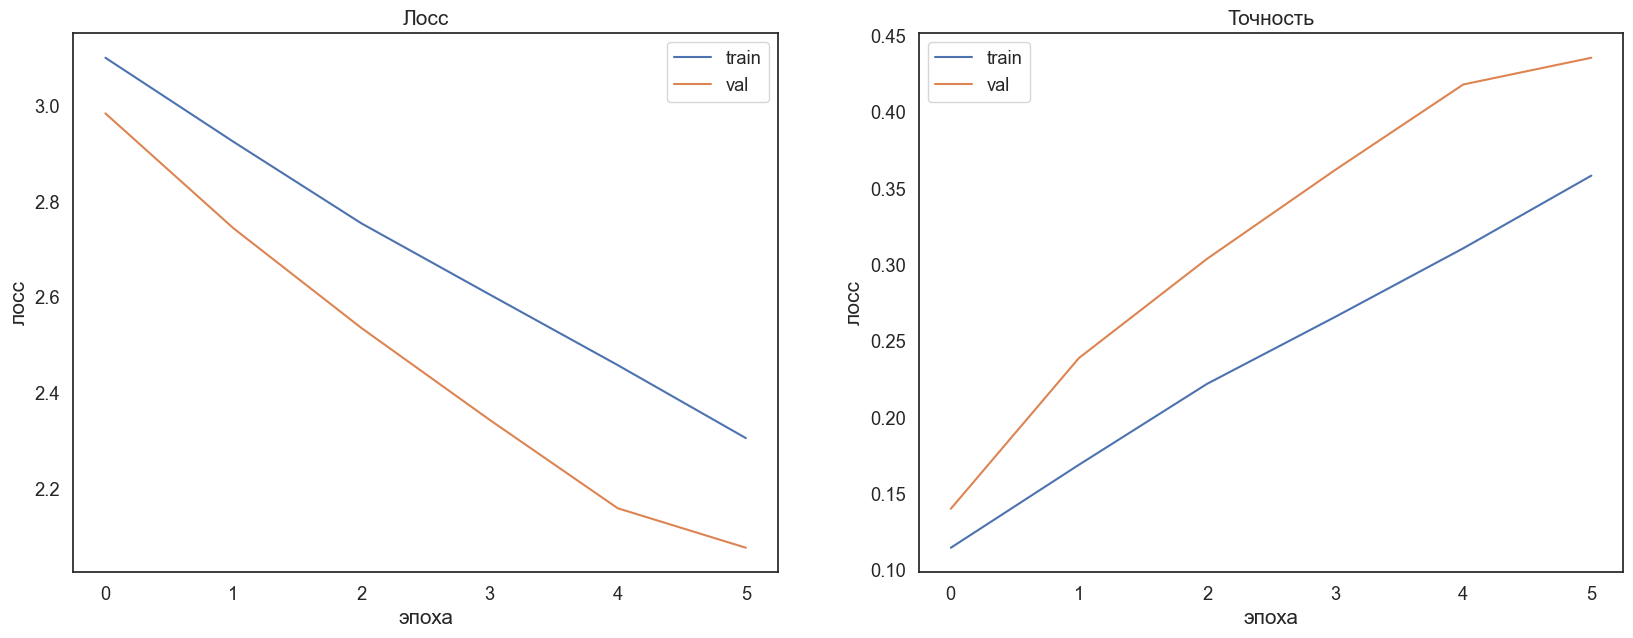

In [11]:
model = resnet18(pretrained=False)
model.fc = nn.Linear(512, 42)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

clf_model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=6
)

### Feature Exctractor

Epoch 6 of 6 took 95.422s
  training loss (in-iteration): 	1.767582
  validation loss (in-iteration): 	1.528050
  training accuracy: 			56.73 %
  validation accuracy: 			63.84 %


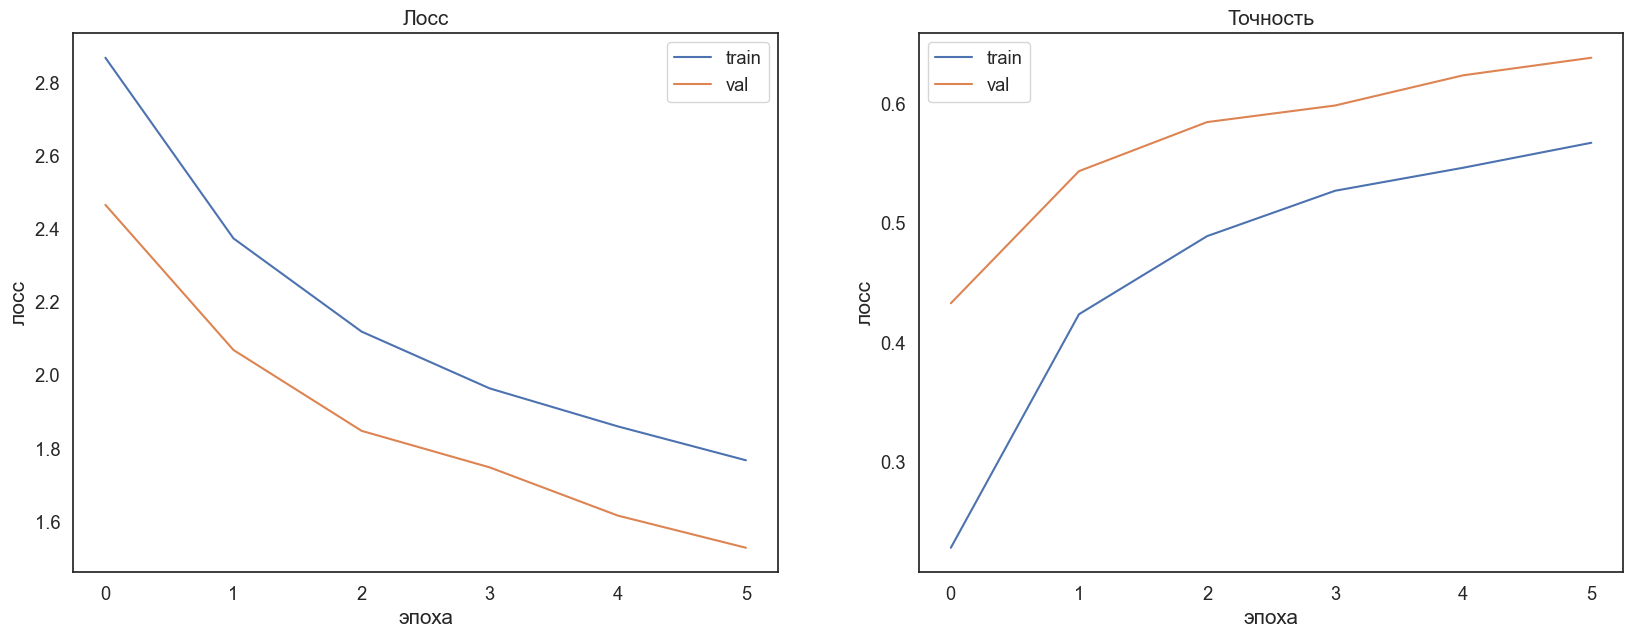

In [12]:
# возьмём предобученную сеть
fe_model = resnet18(pretrained=True)

# заморозим все слои сети
for param in fe_model.parameters():
    param.requires_grad = False

# добавим над feature extractor сетью классификационный слой
fe_model.fc = nn.Linear(512, 42)
fe_model = fe_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fe_model.parameters(), lr=0.01)

clf_model, history = train(
    fe_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=6
)

### FineTuning

Epoch 6 of 6 took 93.723s
  training loss (in-iteration): 	0.208535
  validation loss (in-iteration): 	0.243343
  training accuracy: 			94.51 %
  validation accuracy: 			94.02 %


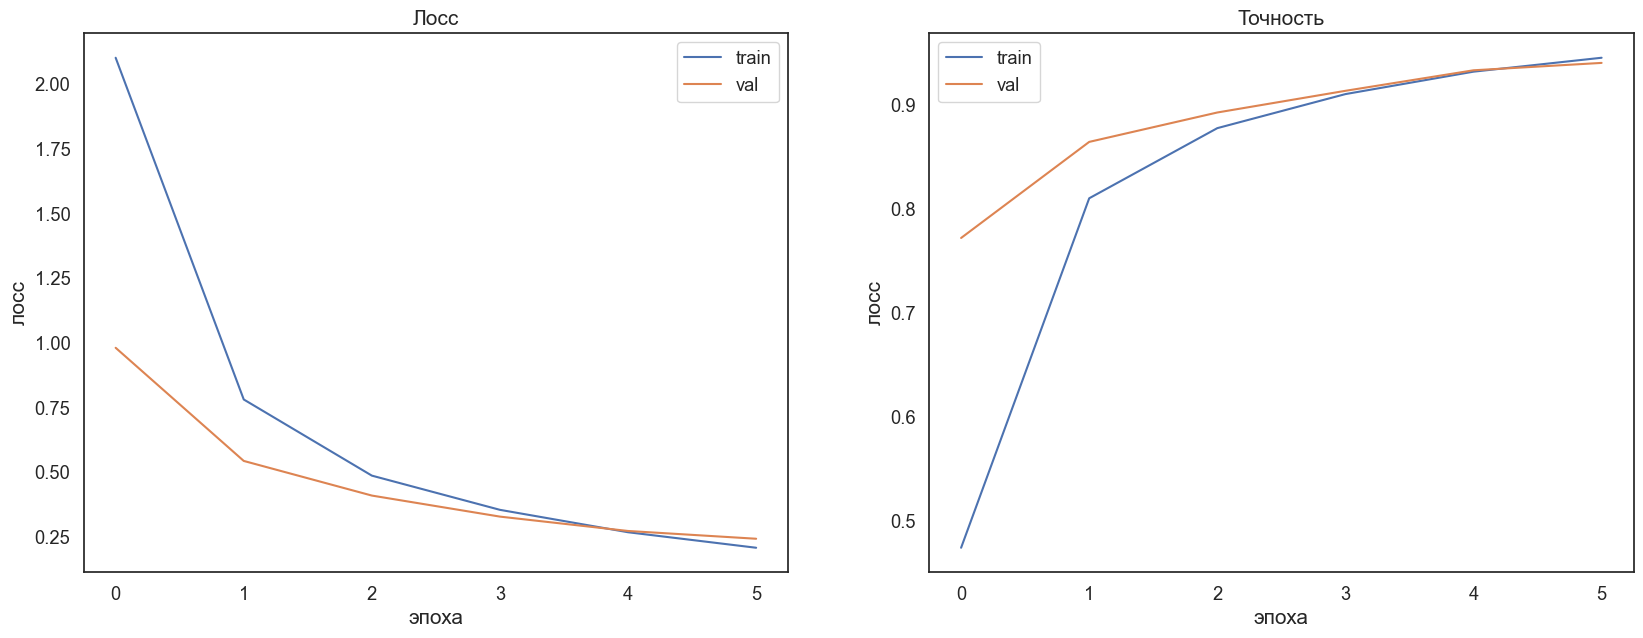

In [13]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

# добавим новые слои для классификации для нашей конкретной задачи
fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=6
)

### 1) LR Schedulers 

In [14]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    scheduler=None,
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)  
            else:
                scheduler.step() 
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

#### ExponentialLR

Epoch 6 of 6 took 94.933s
  training loss (in-iteration): 	0.263558
  validation loss (in-iteration): 	0.277983
  training accuracy: 			93.31 %
  validation accuracy: 			92.85 %


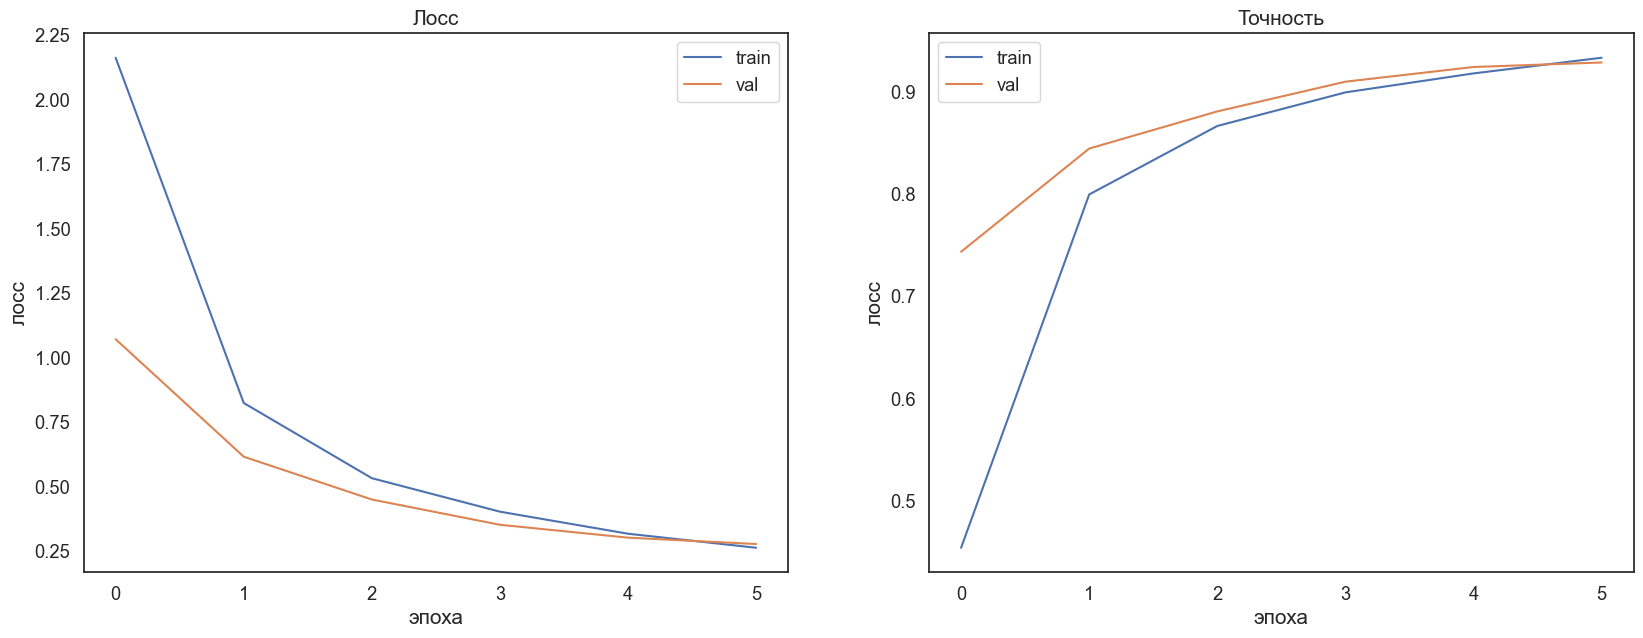

In [15]:
from torch.optim.lr_scheduler import ExponentialLR

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=6, scheduler=scheduler
)

#### ReduceLROnPlateau

Epoch 6 of 6 took 91.898s
  training loss (in-iteration): 	0.221369
  validation loss (in-iteration): 	0.260974
  training accuracy: 			94.40 %
  validation accuracy: 			93.51 %


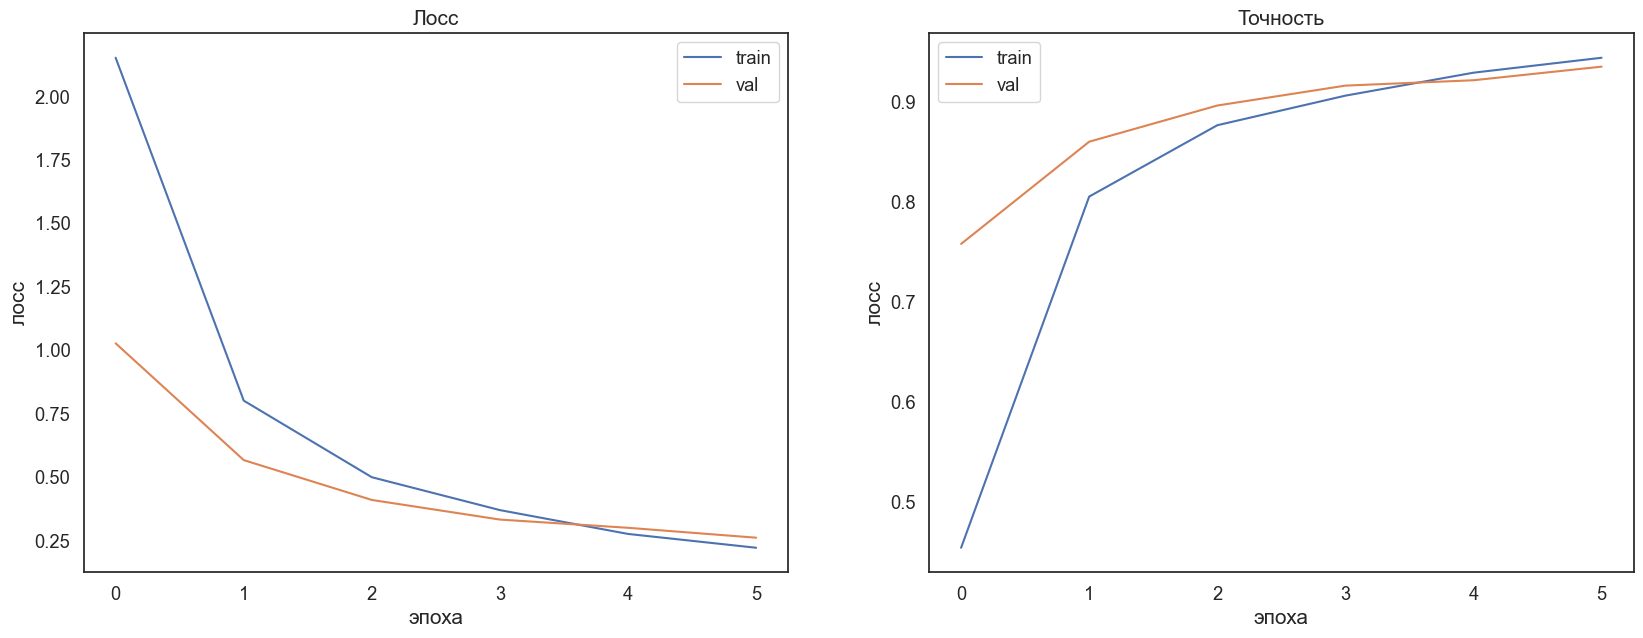

In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=6, scheduler=scheduler
)

### 2) Аугментация

In [30]:
input_size = 224

train_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.RandomAffine(5),
    transforms.RandomApply([transforms.GaussianBlur(21)], p=1.0), 
    transforms.RandomRotation(degrees=180),
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=train_transform,
    is_valid_file=lambda x: x in train_files_path
)

val_dataset = torchvision.datasets.ImageFolder(
    data_dir,
    transform=val_transform,
    is_valid_file=lambda x: x in val_files_path
)

In [31]:
batch_size = 64

# не забудем перемешать train
train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
# валидационный датасет мешать не нужно, а точнее бессмысленно
# сеть на нём не обучается
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Epoch 6 of 6 took 156.294s
  training loss (in-iteration): 	0.803209
  validation loss (in-iteration): 	0.670347
  training accuracy: 			78.63 %
  validation accuracy: 			81.80 %


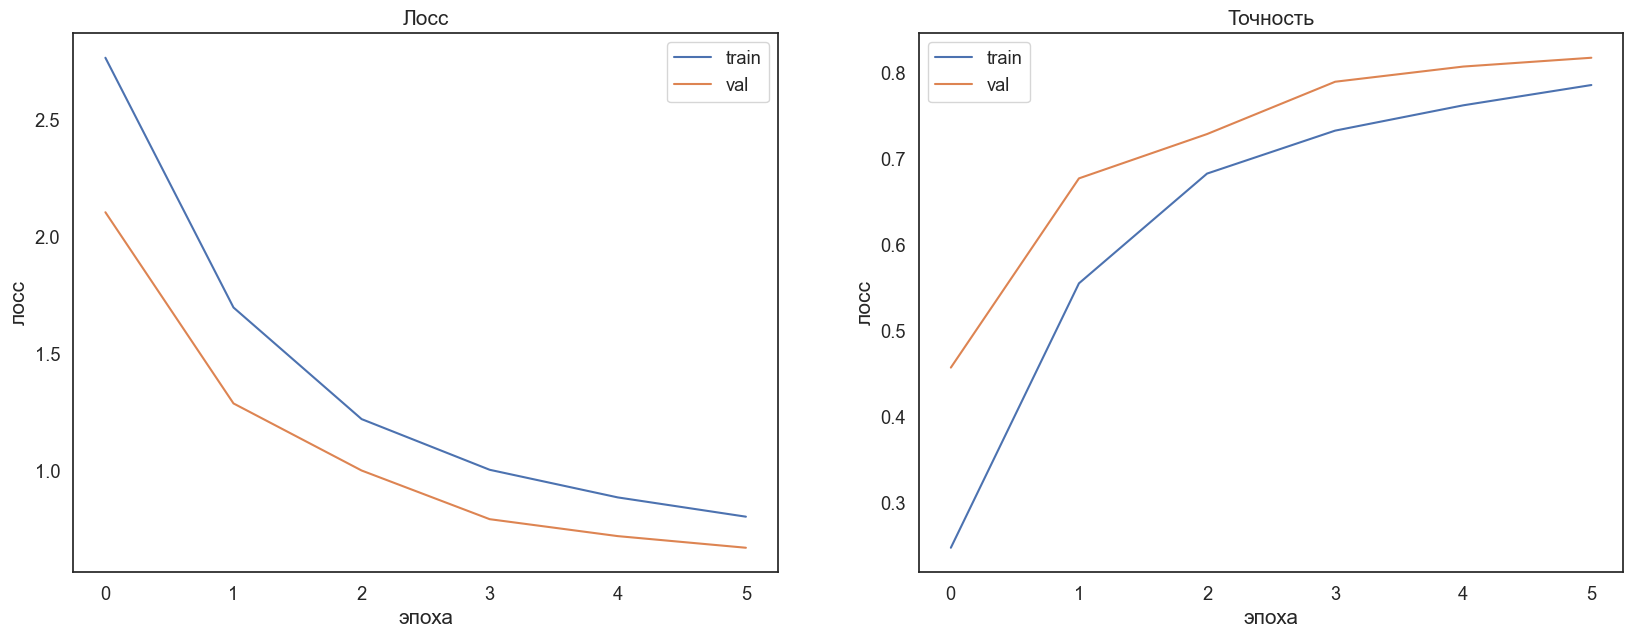

In [32]:
fine_tuning_model = nn.Sequential()

fine_tuning_model.add_module('resnet', resnet18(pretrained=True))

fine_tuning_model.add_module('relu_1', nn.ReLU())
fine_tuning_model.add_module('fc_1', nn.Linear(1000, 512))
fine_tuning_model.add_module('relu_2', nn.ReLU())
fine_tuning_model.add_module('fc_2', nn.Linear(512, 42))

fine_tuning_model = fine_tuning_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuning_model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    fine_tuning_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=6, scheduler=scheduler
)

### 3) MobileNet

#### Будем использовать данные после аугментации из задания 2

In [38]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
    scheduler=None,
    device=None
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # на каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # обучаемся на текущем батче
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            
            loss = criterion(logits, y_batch.long().to(device))

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
    
        # устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # полностью проходим по валидационному датасету  
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            logits = model(X_batch)
            loss = criterion(logits, y_batch.long().to(device))
            val_loss += np.sum(loss.detach().cpu().numpy())
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)  
            else:
                scheduler.step() 
        
        clear_output()

        # печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)
        
    return model, history

Epoch 6 of 6 took 504.625s
  training loss (in-iteration): 	0.631708
  validation loss (in-iteration): 	0.489780
  training accuracy: 			83.29 %
  validation accuracy: 			86.96 %


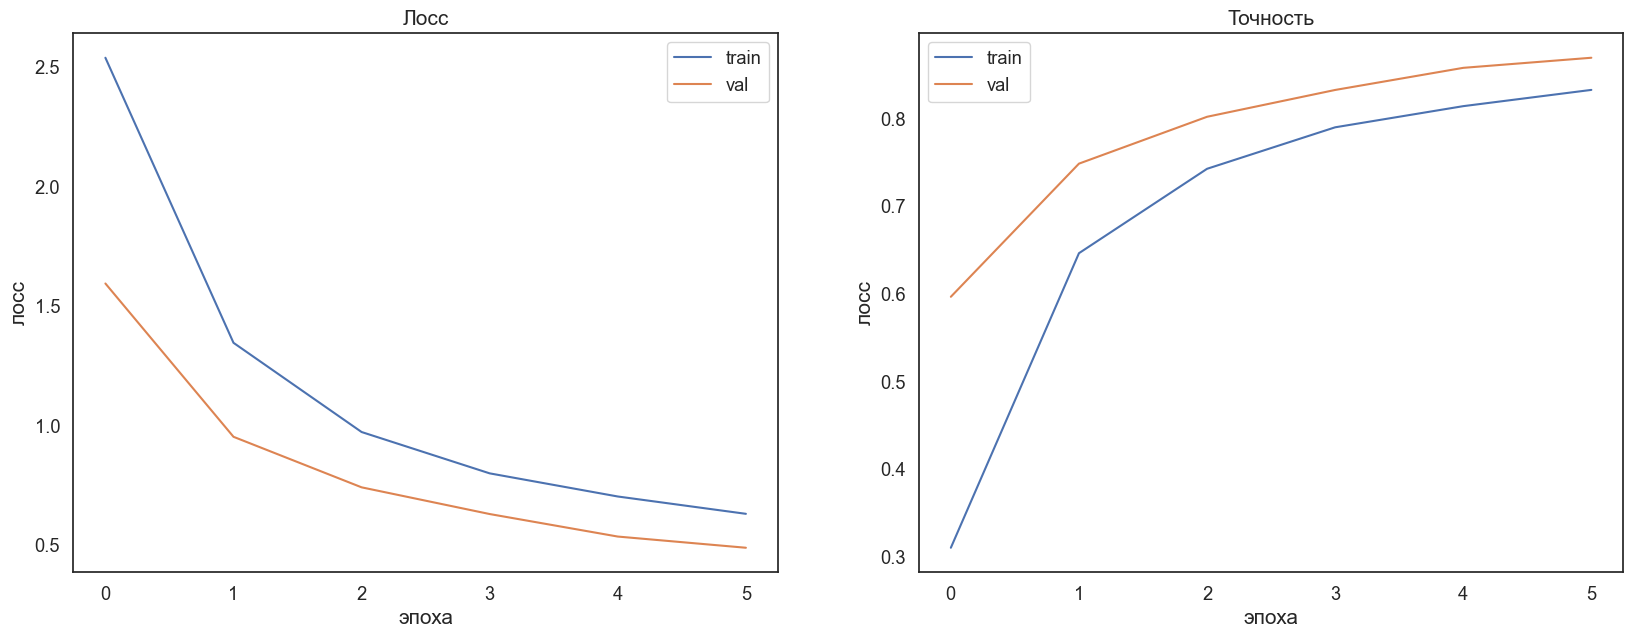

In [39]:
from torchvision.models import mobilenet_v2

device = 'cpu'

mobilenet_model = nn.Sequential()

mobilenet_model.add_module('mobilenet', mobilenet_v2(pretrained=True))

mobilenet_model.add_module('relu_1', nn.ReLU())
mobilenet_model.add_module('fc_1', nn.Linear(1000, 512))  
mobilenet_model.add_module('relu_2', nn.ReLU())
mobilenet_model.add_module('fc_2', nn.Linear(512, 42))

mobilenet_model = mobilenet_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mobilenet_model.parameters(), lr=0.01)
scheduler = ExponentialLR(optimizer, gamma=0.9)

clf_model, history = train(
    mobilenet_model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=6, scheduler=scheduler, device=device
)

### Выводы

In [41]:
import pandas as pd

acc_results = {'Метод': ['С нуля', 'Feature Extractor', 'FineTuning'], 'Val Accuracy': [0.4358, 0.6384, 0.9402]}
df_results = pd.DataFrame(acc_results)
df_results

,Метод,Val Accuracy
0,С нуля,0.4358
1,Feature Extractor,0.6384
2,FineTuning,0.9402


#### FineTuning имеет наилучшую метрики точности, т.к. использует предварительно обученные веса из модели, обученной на наборах данных (ImageNet и т.д.), что позволяет модели быстрее адаптироваться к нашей задаче.

In [42]:
shed_results = {'Scheduler': ['None', 'ExponentialLR', 'ReduceLROnPlateau'], 'Val Accuracy': [0.9402, 0.9285, 0.9351]}
df_results = pd.DataFrame(shed_results)
df_results

,Scheduler,Val Accuracy
0,None,0.9402
1,ExponentialLR,0.9285
2,ReduceLROnPlateau,0.9351


#### Без шедулера модель показала наилучшие результаты, следовательно фиксированная скорость обучения оказалось оптимиальной для данной задачи. ExponentialLR имеет наименьшую метрику точности из-за слишком агрессивного уменьшения скорости обучения. ReduceLROnPlateau на втором месте, т.к. адаптируется к обучению и перестает менять скорость обучения, когда перестает изменяться функция потерь. Т.к. количество эпох было небольшим, параметр, который отслеживает количество эпох без изменений, был выставлен равным 1.

##### Хотелось бы добавить, что для получения лучших результатов можно попробовать использовать Adam и sheduler. Вмести они работают как комбинация локальной и глобальной оптимизации скорости обучения.

In [43]:
aug_results = {'Модель': ['resnet18'], 'Метод': ['FineTuning'], 'Scheduler': ['ExponentialLR'], 'Val Accuracy': [0.818]}
df_results = pd.DataFrame(aug_results)
df_results

,Модель,Метод,Scheduler,Val Accuracy
0,resnet18,FineTuning,ExponentialLR,0.818


#### Для аугментации использовались:
* RandomAffine(5): случайные преобразования (сдвиг, масштабирование, поворот и т.д.) в пределах +- 5 градусов
* RandomApply([GaussianBlur(21)], p=1.0): применение сильного размытия с вероятностью 100%
* RandomRotation(degrees=180): случайный поворот изображения в пределах от -180 до 180 градусов
* ColorJitter(brightness=0.5, contrast=0.5): изменяет яркость и контрастность изображения в пределах +- 50%

С данными настройками получилось ухудшить Accuracy больше чем на 10%

In [44]:
aug_results = {'Модель': ['MobileNet'], 'Метод': ['FineTuning'], 'Scheduler': ['ExponentialLR'], 'Val Accuracy': [0.8696]}
df_results = pd.DataFrame(aug_results)
df_results

,Модель,Метод,Scheduler,Val Accuracy
0,MobileNet,FineTuning,ExponentialLR,0.8696


#### На тех же аугментированных данных была обучена модель MobileNet, которая получила лучшую метрику Accuracy, нежели resnet18. Мною была выбрана именно MobileNet, т.к. она имеет наименьшие вычислительные затраты на обучение. EfficientNet и VGG обучались слишком долго. Важно отметить, что MobileNet была разработана для работы на устройствах с ограниченными вычислительными ресурсами, поэтому она оптимизирована для обучения на CPU. Таким образом, время обучения на CPU равнялось ~500 сек/эпох, а на GPU я не дождался даже одной эпохи